In [71]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
from sklearn.decomposition import PCA
import numpy as np
import datetime
import os

from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from models.vae import DenseVariationalAutoencoder

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

TRAINING_FRACTION = 0.8
N_DENSE = 2
L=4
NON_LINEAR_ACTIVATION_BOOL=True

In [72]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'xy'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [73]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"
    
tensorboard_log_dir = "{}/logs/fit/".format(prefix_s3) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [74]:
# Just do this so it is easier to configure arbitrary choices
work_with_t_list = [ "00.10", "00.20", "00.30", "00.40", "00.50", "00.60", "00.70", "00.80", "00.90", "01.00", "01.10", "01.20", "01.30", "01.40", "01.50", "01.60", "01.70", "01.80", "01.90", "02.00"]

In [75]:
df_bins = None
df_conf = None
for i, t_string in enumerate(work_with_t_list):
    bins_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/bins_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    configs_f_name = "{prefix_data}z3support/data/XYMLData/2DXY-configs-L-{l}/spinConfigs_2DXY-configs-L-{l}-{l}-{t}-0000.txt".format(
        l = str(L).zfill(4),
        t = t_string,
        prefix_data = prefix_data
    )
    if i == 0:
        df_bins = pd.read_csv(bins_f_name, sep="\t")
        df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
    else:
        cur_df_bins = pd.read_csv(bins_f_name, sep="\t")
        cur_df_conf = pd.read_csv(configs_f_name, delimiter=r"\s+", header=None)
        df_bins = df_bins.append(cur_df_bins) 
        df_conf = df_conf.append(cur_df_conf) 
    print(bins_f_name)

/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.10-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.20-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.30-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.40-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.50-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.60-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.70-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.80-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-configs-L-0004/bins_2DXY-configs-L-0004-0004-00.90-0000.txt
/home/owen/repos/z3support/data/XYMLData/2DXY-

In [76]:
df_bins.shape

(200000, 10)

In [77]:
df_bins = df_bins.astype(
    {
        " T ": float,
        " binNum": int,
    }
)

In [78]:
df_conf["T"] = df_bins[" T "]

In [79]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [80]:
df_conf["M"] = mean_col

In [81]:
df_conf.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 'T', 'M'], dtype='object')

In [82]:
df_conf.shape

(200000, 18)

In [83]:
df_conf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,T,M
0,0.162246,5.973095,6.133531,6.156717,0.025063,6.050038,6.020508,6.223365,0.067779,6.153401,6.032560,0.073008,6.134114,6.160847,0.052111,0.115091,0.1,4.606397
1,4.983357,4.822849,4.691446,4.885390,5.122919,4.853683,4.793827,4.921220,4.869675,5.132625,5.236716,4.908288,4.935758,4.859949,4.700985,5.001698,0.1,4.845760
2,2.727240,2.390374,2.708473,2.618912,2.354293,2.384652,2.535973,2.779869,2.592872,2.413333,2.715683,2.716086,2.763101,2.847251,2.660584,2.721994,0.1,2.611250
3,5.762936,5.839879,0.023180,6.216394,6.118754,6.144861,0.033664,0.032085,6.282960,0.085963,0.031738,0.152408,6.027732,6.234099,0.083261,0.023046,0.1,4.460597
4,4.463147,4.564015,4.342138,4.595675,4.269949,4.323170,4.407668,4.411044,4.368104,4.413393,4.490482,4.530060,4.503687,4.435605,4.239925,4.452277,0.1,4.491244


In [84]:
cols = []
for i in range(L*L):
    cols.append(str(i))
    cols.append(str(i))
print(cols)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15']


In [85]:
xy_spec = ["x", "y"] * L*L

In [86]:
for i in zip(cols, xy_spec):
    continue
    #print(i)

In [87]:
np_angle_matrix = df_conf.drop(["T","M"], axis=1).to_numpy()

In [88]:
np_x_matrix = np.cos(np_angle_matrix)
np_y_matrix = np.sin(np_angle_matrix)

In [89]:
#np.concatenate(np_x_matrix, np_x_matrix, axis=1)
df = pd.DataFrame(columns=pd.MultiIndex.from_tuples(zip(cols, xy_spec)))

In [90]:
df.sort_index(ascending=True, inplace=True, axis=1)

In [91]:
df.loc[:, (slice(None), slice("x"))] = np_x_matrix

In [92]:
np_x_matrix

array([[ 0.986867  ,  0.9523061 ,  0.98882268, ...,  0.99252601,
         0.99864253,  0.99338439],
       [ 0.26766423,  0.11023518, -0.0209416 , ...,  0.14702497,
        -0.01140408,  0.28528988],
       [-0.91537707, -0.73085744, -0.90766075, ..., -0.95699346,
        -0.88652882, -0.91325267],
       ...,
       [-0.99830957,  0.0421496 ,  0.89964396, ...,  0.21996072,
        -0.50070655,  0.84040243],
       [ 0.82732545, -0.5923434 , -0.93039124, ...,  0.97941924,
         0.99797575,  0.46533788],
       [-0.13212106, -0.07885553, -0.83045631, ..., -0.38073196,
        -0.00149156, -0.17984246]])

In [93]:
np_y_matrix

array([[ 0.16153491, -0.30514438, -0.14909632, ..., -0.12203327,
         0.05208737,  0.11483667],
       [-0.96351225, -0.99390553, -0.9997807 , ..., -0.98913278,
        -0.99993497, -0.95844128],
       [ 0.40259759,  0.68253015,  0.41970462, ...,  0.29010949,
         0.46267338,  0.40739362],
       ...,
       [ 0.05812054,  0.99911131,  0.43662425, ..., -0.97550873,
         0.86561709, -0.54196287],
       [ 0.56172289,  0.80568561,  0.36656806, ...,  0.20183644,
        -0.06359564,  0.88513313],
       [-0.99123359, -0.99688605,  0.55708377, ...,  0.92468545,
         0.99999889, -0.98369542]])

In [94]:
df.loc[:, (slice(None), "y")] = np_y_matrix

In [95]:
df

0                   1                  10                  11  \
               x         y         x         y         x         y         x   
0       0.986867  0.161535  0.952306 -0.305144  0.988823 -0.149096  0.992013   
1       0.267664 -0.963512  0.110235 -0.993906 -0.020942 -0.999781  0.172139   
2      -0.915377  0.402598 -0.730857  0.682530 -0.907661  0.419705 -0.866484   
3       0.867695 -0.497097  0.903339 -0.428928  0.999731  0.023177  0.997770   
4      -0.246669 -0.969100 -0.147830 -0.989013 -0.361850 -0.932236 -0.116449   
...          ...       ...       ...       ...       ...       ...       ...   
199995 -0.380816  0.924651  0.435527  0.900176 -0.992033  0.125981 -0.960587   
199996  0.599849  0.800113 -0.901182  0.433442  0.110907 -0.993831 -0.260379   
199997 -0.998310  0.058121  0.042150  0.999111  0.899644  0.436624  0.981281   
199998  0.827325  0.561723 -0.592343  0.805686 -0.930391  0.366568  0.705829   
199999 -0.132121 -0.991234 -0.078856 -0.996886 -0.830456  0.557084  0.912044   

                        12            ...         5                   6  \
               y         x         y  ...         x         y         x   
0      -0.126132  0.999686  0.025061  ...  0.997336  0.072943  0.988909   
1      -0.985073  0.399095 -0.916909  ...  0.194648 -0.980873  0.221516   
2       0.499204 -0.705761  0.708450  ... -0.910830  0.412782 -0.929223   
3      -0.066742  0.986512 -0.163692  ...  0.988408  0.151819  0.967549   
4      -0.993197 -0.428146 -0.903710  ... -0.181321 -0.983424 -0.207191   
...          ...       ...       ...  ...       ...       ...       ...   
199995  0.277981 -0.778302  0.627890  ... -0.934569  0.355781 -0.953145   
199996  0.965507  0.960891 -0.276929  ...  0.862163 -0.506631  0.249771   
199997  0.192584 -0.785513 -0.618845  ...  0.686430 -0.727196  0.770983   
199998  0.708382  0.868733 -0.495281  ... -0.681993  0.731359 -0.858536   
199999  0.410093 -0.956530  0.291633  ... -0.751057 -0.660238 -0.531589   

                         7                   8                   9            
               y         x         y         x         y         x         y  
0      -0.148520  0.992526 -0.122033  0.998643  0.052087  0.993384  0.114837  
1      -0.975157  0.147025 -0.989133 -0.011404 -0.999935  0.285290 -0.958441  
2       0.369519 -0.956993  0.290109 -0.886529  0.462673 -0.913253  0.407394  
3      -0.252684  0.998796 -0.049066  0.996536  0.083165  0.999734  0.023044  
4      -0.978301 -0.273263 -0.961939 -0.455082 -0.890450 -0.257189 -0.966361  
...          ...       ...       ...       ...       ...       ...       ...  
199995  0.302513 -0.190073 -0.981770 -0.903206  0.429207  0.218889  0.975750  
199996  0.968305 -0.818960  0.573851 -0.532814 -0.846232  0.187749  0.982217  
199997 -0.636856  0.219961 -0.975509 -0.500707  0.865617  0.840402 -0.541963  
199998  0.512753  0.979419  0.201836  0.997976 -0.063596  0.465338  0.885133  
199999 -0.847003 -0.380732  0.924685 -0.001492  0.999999 -0.179842 -0.983695  

[200000 rows x 32 columns]

In [96]:
train_with_meta_info = df.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = df.drop(index=train_with_meta_info.index)
#train = train_with_meta_info.drop(["T","M"], axis=1)
#test = test_with_meta_info.drop(["T","M"], axis=1)
train = train_with_meta_info
test = test_with_meta_info

In [97]:
img_pca = PCA(n_components=N_DENSE)
img_pca.fit(train.to_numpy())

PCA(n_components=2)

In [98]:
components = img_pca.transform(df.to_numpy())

In [99]:
df.to_numpy().shape

(200000, 32)

In [100]:
components.shape

(200000, 2)

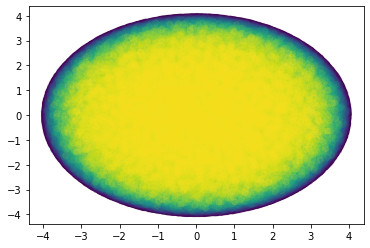

In [101]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["T"]), alpha=0.1)

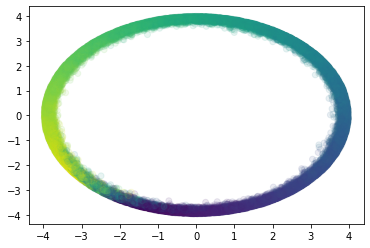

In [32]:
if N_DENSE > 1:
    plt.scatter(components[:,0], components[:,1], c=pd.to_numeric(df_conf["M"]), alpha=0.1)

# Dense AE

In [102]:
simp_ae = tf.keras.Sequential(
    [
        keras.layers.InputLayer(input_shape=(L*L*2,)),
        keras.layers.Dense(N_DENSE, use_bias=False, name='latent_space'),
        keras.layers.Dense(L*L*2),
    ]
)

print(simp_ae.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 latent_space (Dense)        (None, 2)                 64        
                                                                 
 dense_17 (Dense)            (None, 32)                96        
                                                                 
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________
None


In [103]:
tb_callback = keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=0,  
    write_graph=True,
    write_images=True
)

simp_ae.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [104]:
simp_ae.fit(
    batch_size=16,
    x=train.to_numpy(),
    y=train.to_numpy(),
    epochs=20,
    callbacks=[tb_callback]
)

Epoch 1/20
10000/10000 [==============================] - 9s 879us/step - loss: 0.2013 - mae: 0.3359
Epoch 2/20
10000/10000 [==============================] - 9s 932us/step - loss: 0.1912 - mae: 0.3259
Epoch 3/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1912 - mae: 0.3259
Epoch 4/20
10000/10000 [==============================] - 9s 934us/step - loss: 0.1912 - mae: 0.3258
Epoch 5/20
10000/10000 [==============================] - 9s 924us/step - loss: 0.1912 - mae: 0.3258
Epoch 6/20
10000/10000 [==============================] - 10s 1ms/step - loss: 0.1912 - mae: 0.3258
Epoch 7/20
10000/10000 [==============================] - 9s 914us/step - loss: 0.1912 - mae: 0.3258
Epoch 8/20
10000/10000 [==============================] - 9s 930us/step - loss: 0.1912 - mae: 0.3258
Epoch 9/20
10000/10000 [==============================] - 10s 999us/step - loss: 0.1912 - mae: 0.3258
Epoch 10/20
10000/10000 [==============================] - 10s 956us/step - loss: 0.1911 - m

In [105]:
mid_layer = simp_ae.get_layer('latent_space')

In [106]:
mid_layer.get_weights()[0].shape

(32, 2)

In [107]:
extractor = keras.Model(inputs=simp_ae.inputs,
                        outputs=[layer.output for layer in simp_ae.layers])

In [108]:
features = extractor(df.to_numpy())

2022-08-26 14:50:59.459946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51200000 exceeds 10% of free system memory.


In [109]:
features[0].numpy()

array([[-0.4270155 ,  1.3171233 ],
       [-1.415068  , -0.00309622],
       [ 0.9604583 , -1.0221668 ],
       ...,
       [ 0.13464119,  0.6059762 ],
       [ 0.65923715,  0.12515543],
       [ 0.19425261, -0.3120141 ]], dtype=float32)

In [110]:
features[0][:,0]

<tf.Tensor: shape=(200000,), dtype=float32, numpy=
array([-0.4270155 , -1.415068  ,  0.9604583 , ...,  0.13464119,
        0.65923715,  0.19425261], dtype=float32)>

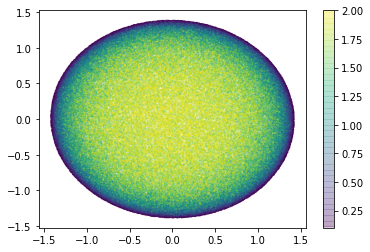

In [111]:
plt.scatter(features[0][:,0], features[0][:,1], c=df_conf["T"], s=0.5, alpha=0.2)
plt.colorbar()

# Dense VAE

In [60]:
x = train.to_numpy().reshape(-1,L*L*2)
x_test = test.to_numpy().reshape(-1,L*L*2)
x = x.astype(float)
x_test = x_test.astype(float)

In [61]:
print(x.shape)
print(x_test.shape)

(24000, 32)
(6000, 32)


In [62]:
print(type(x))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [63]:
#x = x+10
#x_test = x_test+10

In [65]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L*2,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L*2],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [66]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 1000

In [67]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [68]:
BATCH_SIZE = 16
EPOCHS = 5
PRINT_EVERY_N_BATCHES = 10
INITIAL_EPOCH = 0

In [69]:
r = vae.train(     
    x,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    run_folder = RUN_FOLDER,
    print_every_n_batches = PRINT_EVERY_N_BATCHES,
    initial_epoch = INITIAL_EPOCH,
    x_test=tf.data.Dataset.from_tensor_slices(x_test)
)

Epoch 1/5


TypeError: in user code:

    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/metrics/base_metric.py", line 449, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_11'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
